This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/roebius/pj/p3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# import warnings

# warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
limit_mem()

# Tiramisu / Camvid

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. It was designed as a state-of-the-art approach to semantic image segmentation.

We're going to use the same dataset they did, CamVid.

CamVid is a dataset of images from a video. It has ~ 600 images, so it's quite small, and given that it is from a video the information content of the dataset is small. 

We're going to train this Tiramisu network from scratch to segment the CamVid dataset. This seems extremely ambitious!

## Setup

Modify the following to point to the appropriate paths on your machine

In [4]:
PATH = '/data/datasets/SegNet-Tutorial/CamVid/'

In [5]:
frames_path = PATH+'all/'

In [6]:
labels_path = PATH+'allannot/'

In [7]:
PATH = 'data/camvid/'  # - used this path as main dataset ir

The images in CamVid come with labels defining the segments of the input image. We're going to load both the images and the labels.

In [8]:
frames_path = PATH+'701_StillsRaw_full/'  # - used this path for the images

In [9]:
labels_path = PATH+'LabeledApproved_full/'  # - used this path for the label images

In [10]:
fnames = glob.glob(frames_path+'*.png')

In [11]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]
# lnames = [labels_path+os.path.basename(fn)[:-4]+'.png' for fn in fnames]

In [12]:
img_sz = (480,360)

Helper function to resize images.

In [13]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [14]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)

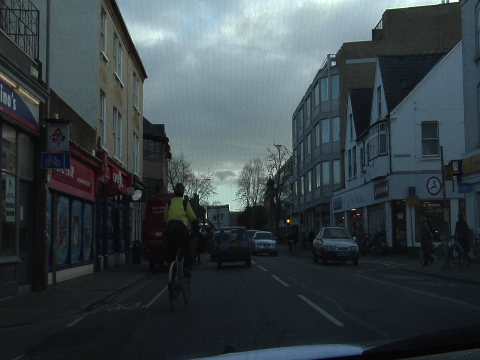

In [15]:
img

In [16]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [17]:
labels = np.stack([open_image(fn) for fn in lnames])

In [18]:
imgs.shape,labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

Normalize pixel values.

Save array for easier use.

In [19]:
save_array(PATH+'results/imgs.bc', imgs)
save_array(PATH+'results/labels.bc', labels)

In [20]:
imgs = load_array(PATH+'results/imgs.bc')
labels = load_array(PATH+'results/labels.bc')

Standardize

In [21]:
imgs = imgs/256  # - depending on the dataset, the imgs array might need to be scaled first (it's my case)
imgs-=0.4
imgs/=0.3

In [22]:
n,r,c,ch = imgs.shape
n,r,c,ch

(701, 360, 480, 3)

## Preprocessing

### Generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [23]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [24]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [25]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([1, 9, 2]),
 array([4, 7, 8]),
 array([0, 6, 5]),
 array([3]),
 array([5, 0, 4])]

In [26]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the first image.

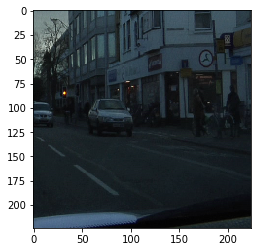

In [27]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

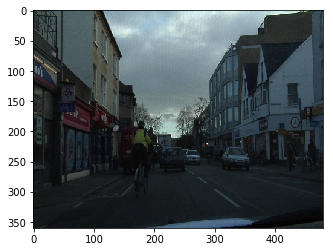

In [28]:
plt.imshow(imgs[0]*0.3+0.4);

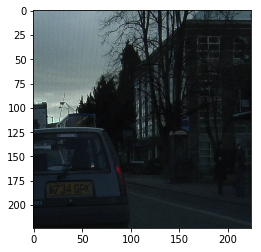

In [29]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

In [30]:
# - Commented out original function and replaced with a modified function.
# - The modified function should be able to split also on multiple tab sequences

# def parse_code_with_re(l):
#     a,b = l.strip().split("\t")
#     return tuple(int(o) for o in a.split(' ')), b

import re
def parse_code(l):
    a,b = re.split('\\t+', l)  # - splits on one or more subsequent tabs, should they occur
    return tuple(int(o) for o in a.split(' ')), b[:-1]  # - [:-1] leaves out the newline at the end of each line

In [31]:
label_codes,label_names = zip(*[
    parse_code(l) for l in open(PATH+"label_colors.txt")])

In [32]:
label_codes,label_names = list(label_codes),list(label_names)

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [33]:
# - I removed the [:5] slice in order to display all the labels (each label should correspond to a class)
# - Note: in the label_colors.txt file used here there are 32 labels
list(zip(label_codes,label_names))

[((64, 128, 64), 'Animal'),
 ((192, 0, 128), 'Archway'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 128, 64), 'Bridge'),
 ((128, 0, 0), 'Building'),
 ((64, 0, 128), 'Car'),
 ((64, 0, 192), 'CartLuggagePram'),
 ((192, 128, 64), 'Child'),
 ((192, 192, 128), 'Column_Pole'),
 ((64, 64, 128), 'Fence'),
 ((128, 0, 192), 'LaneMkgsDriv'),
 ((192, 0, 64), 'LaneMkgsNonDriv'),
 ((128, 128, 64), 'Misc_Text'),
 ((192, 0, 192), 'MotorcycleScooter'),
 ((128, 64, 64), 'OtherMoving'),
 ((64, 192, 128), 'ParkingBlock'),
 ((64, 64, 0), 'Pedestrian'),
 ((128, 64, 128), 'Road'),
 ((128, 128, 192), 'RoadShoulder'),
 ((0, 0, 192), 'Sidewalk'),
 ((192, 128, 128), 'SignSymbol'),
 ((128, 128, 128), 'Sky'),
 ((64, 128, 192), 'SUVPickupTruck'),
 ((0, 0, 64), 'TrafficCone'),
 ((0, 64, 64), 'TrafficLight'),
 ((192, 64, 128), 'Train'),
 ((128, 128, 0), 'Tree'),
 ((192, 128, 192), 'Truck_Bus'),
 ((64, 0, 64), 'Tunnel'),
 ((192, 192, 0), 'VegetationMisc'),
 ((0, 0, 0), 'Void'),
 ((64, 192, 0), 'Wall')]

We're going to map each unique pixel color to an integer so we can classify w/ our NN. (Think how a fill-in-the color image looks)

In [34]:
code2id = {v:k for k,v in enumerate(label_codes)}

We'll include an integer for erroneous pixel values.

In [35]:
failed_code = len(label_codes)+1

In [36]:
label_codes.append((0,0,0))
label_names.append('unk')

In [37]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [38]:
from concurrent.futures import ProcessPoolExecutor

In [39]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

In [40]:
%time labels_int =conv_all_labels()

CPU times: user 588 ms, sys: 312 ms, total: 900 ms
Wall time: 1min 49s


In [41]:
np.count_nonzero(labels_int==failed_code)

44

Set erroneous pixels to zero.

In [42]:
labels_int[labels_int==failed_code]=0

In [43]:
save_array(PATH+'results/labels_int.bc', labels_int)

In [44]:
labels_int = load_array(PATH+'results/labels_int.bc')

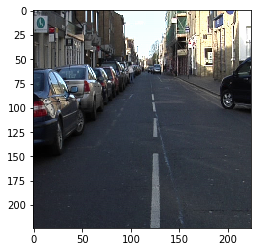

In [45]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

Here is an example of how the segmented image looks.

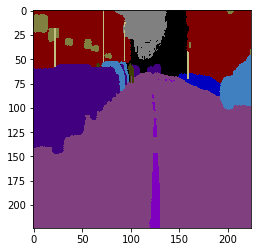

In [46]:
plt.imshow(b_label[0].reshape(224,224,3));

### Test set

Next we load test set, set training/test images and labels.

In [47]:
fn_test = set(o.strip() for o in open(PATH+'test.txt','r'))

In [48]:
is_test = np.array([o.split('/')[-1] in fn_test for o in fnames])

In [49]:
trn = imgs[is_test==False]
trn_labels = labels_int[is_test==False]
test = imgs[is_test]
test_labels = labels_int[is_test]
trn.shape,test.shape

((468, 360, 480, 3), (233, 360, 480, 3))

In [50]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [51]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)  # Keras 2
def relu_bn(x): return relu(bn(x))
def concat(xs): return concatenate(xs)  # Keras 2

In [52]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, (sz, sz), kernel_initializer='he_uniform', padding='same',   # Keras 2
                      strides=(stride,stride), kernel_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [53]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [54]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)  # - original idea from the paper
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)  # - seems to work better

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [55]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [56]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
#     return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
#                border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
    return Conv2DTranspose(ch, (3,3), kernel_initializer='he_uniform',    # Keras 2
               padding='same', strides=(2,2), kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [57]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [58]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [59]:
# def create_tiramisu(nb_classes, img_input, nb_dense_block=6,  # - - changed the original nb_dense_block=6 
#     growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):  # - changed the original growth_rate=16 
    
#     if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
#         nb_layers = list(nb_layers_per_block)
#     else: nb_layers = [nb_layers_per_block] * nb_dense_block

#     x = conv(img_input, nb_filter, 3, wd, 0)
#     skips,added = down_path(x, nb_layers, growth_rate, p, wd)
#     x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
#     x = conv(x, nb_classes, 1, wd, 0)
# #     _,r,c,f = x.get_shape().as_list()
#     x = Reshape((-1, nb_classes))(x)
#     return Activation('softmax')(x)
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [60]:
limit_mem()

In [92]:
input_shape = (224,224,3)

In [93]:
img_input = Input(shape=input_shape)

In [63]:
# - The classes based on the labels in the label_colors.txt file used here are 32
# x = create_tiramisu(12, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [64]:
model = Model(img_input, x)

In [95]:
gen = segm_generator(trn, trn_labels, 3, train=True)

In [96]:
gen_test = segm_generator(test, test_labels, 3, train=False)

In [67]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [68]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [69]:
model.optimizer=keras.optimizers.RMSprop((1e-3))

In [70]:
K.set_value(model.optimizer.lr, 1e-3)  # - this overrides the lr value assigned in previous 2 cells ...

In [75]:
# - Calculate steps_per_epoch and validation_steps required by model.fit_generator
batch_size = 8
steps_per_epoch = int(np.ceil(rnd_trn/batch_size))
validation_steps = int(np.ceil(rnd_test/batch_size))
rnd_trn, steps_per_epoch, rnd_test, validation_steps

(468, 59, 233, 30)

In [76]:
model.fit_generator(gen, steps_per_epoch, epochs=100, verbose=2,
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/100
46s - loss: 1.2796 - acc: 0.6462 - val_loss: 1.3146 - val_acc: 0.6686
Epoch 2/100
46s - loss: 1.2938 - acc: 0.6402 - val_loss: 1.3738 - val_acc: 0.6468
Epoch 3/100
46s - loss: 1.2258 - acc: 0.6654 - val_loss: 1.2687 - val_acc: 0.6649
Epoch 4/100
46s - loss: 1.2275 - acc: 0.6714 - val_loss: 2.0496 - val_acc: 0.4821
Epoch 5/100
46s - loss: 1.2495 - acc: 0.6618 - val_loss: 1.4296 - val_acc: 0.6271
Epoch 6/100
46s - loss: 1.2136 - acc: 0.6762 - val_loss: 1.3856 - val_acc: 0.6349
Epoch 7/100
46s - loss: 1.1706 - acc: 0.6885 - val_loss: 1.2168 - val_acc: 0.6905
Epoch 8/100
46s - loss: 1.1141 - acc: 0.6939 - val_loss: 1.2369 - val_acc: 0.7039
Epoch 9/100
46s - loss: 1.1592 - acc: 0.6823 - val_loss: 1.3657 - val_acc: 0.6244
Epoch 10/100
46s - loss: 1.1448 - acc: 0.6939 - val_loss: 1.4704 - val_acc: 0.6335
Epoch 11/100
46s - loss: 1.1192 - acc: 0.7002 - val_loss: 1.1156 - val_acc: 0.7054
Epoch 12/100
46s - loss: 1.1474 - acc: 0.6967 - val_loss: 1.1481 - val_acc: 0.7077
Epoch 13/100


KeyboardInterrupt: 

In [77]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [78]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/500
47s - loss: 1.0564 - acc: 0.7152 - val_loss: 1.3533 - val_acc: 0.6558
Epoch 2/500
46s - loss: 1.1531 - acc: 0.6868 - val_loss: 1.1824 - val_acc: 0.6962
Epoch 3/500
46s - loss: 1.0943 - acc: 0.7069 - val_loss: 1.2057 - val_acc: 0.6941
Epoch 4/500
46s - loss: 1.0964 - acc: 0.7018 - val_loss: 1.2240 - val_acc: 0.6759
Epoch 5/500
46s - loss: 1.0438 - acc: 0.7215 - val_loss: 1.1650 - val_acc: 0.7037
Epoch 6/500


KeyboardInterrupt: 

In [79]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [80]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/500
47s - loss: 1.0264 - acc: 0.7253 - val_loss: 1.1787 - val_acc: 0.6970
Epoch 2/500
46s - loss: 1.0457 - acc: 0.7227 - val_loss: 1.1722 - val_acc: 0.6905
Epoch 3/500
46s - loss: 1.0297 - acc: 0.7237 - val_loss: 1.1737 - val_acc: 0.7220
Epoch 4/500
46s - loss: 0.9880 - acc: 0.7351 - val_loss: 1.8097 - val_acc: 0.6093
Epoch 5/500


KeyboardInterrupt: 

In [81]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [97]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/500


KeyboardInterrupt: 

In [83]:
lrg_sz = (352,480)
gen = segm_generator(trn, trn_labels, 2, out_sz=lrg_sz, train=True)
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [84]:
lrg_shape = lrg_sz+(3,)
lrg_input = Input(shape=lrg_shape)

In [85]:
# - As previously mentioned for the first model, we are working with 32 classses
# x = create_tiramisu(12, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
x = create_tiramisu(32, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [86]:
lrg_model = Model(lrg_input, x)

In [87]:
lrg_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-4), metrics=["accuracy"])

In [89]:
# - Reduced the step size to avoid exhausting the GPU memory, without success
batch_size = 1
steps_per_epoch = int(np.ceil(rnd_trn/batch_size))
validation_steps = int(np.ceil(rnd_test/batch_size))
rnd_trn, steps_per_epoch, rnd_test, validation_steps

(468, 468, 233, 233)

In [90]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=100, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[2,352,480,32]
	 [[Node: conv2d_198/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concatenate_202/concat, conv2d_198/kernel/read)]]
	 [[Node: Mean_7/_5069 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_72645_Mean_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_198/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-26d1e14f5b5c>", line 3, in <module>
    x = create_tiramisu(32, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
  File "<ipython-input-59-666f1f8efe67>", line 27, in create_tiramisu
    x = conv(x, nb_classes, 1, wd, 0)
  File "<ipython-input-52-0542c9226f39>", line 3, in conv
    strides=(stride,stride), kernel_regularizer=l2(wd))(x)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3156, in conv2d
    data_format='NHWC')
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/roebius/pj/p3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2,352,480,32]
	 [[Node: conv2d_198/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concatenate_202/concat, conv2d_198/kernel/read)]]
	 [[Node: Mean_7/_5069 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_72645_Mean_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=100, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

In [ ]:
lrg_model.optimizer=keras.optimizers.RMSprop(1e-5)

In [ ]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=2, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

In [ ]:
lrg_model.save_weights(PATH+'results/8758.h5')

## View results

Let's take a look at some of the results we achieved.

### # - case with 12 classes

In [ ]:
colors = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
         (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128), (64, 64, 0),
         (0, 128, 192), (0, 0, 0)]
names = ['sky', 'building', 'column_pole', 'road', 'sidewalk', 'tree', 
                'sign', 'fence', 'car', 'pedestrian', 'bicyclist', 'void']

In [ ]:
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [ ]:
preds = lrg_model.predict_generator(gen_test, rnd_test)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,352,480))

In [ ]:
target = test_labels.reshape((233,360,480))[:,8:]

In [ ]:
(target == preds).mean()

In [ ]:
non_void = target != 11
(target[non_void] == preds[non_void]).mean()

In [ ]:
idx=1

In [ ]:
p=lrg_model.predict(np.expand_dims(test[idx,8:],0))
p = np.argmax(p[0],-1).reshape(352,480)
pred = color_label(p)

This is pretty good! We can see it is having some difficulty with the street between the light posts, but we would expect that a model that was pre-trained on a much larger dataset would perform better.

In [ ]:
plt.imshow(pred);

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(test[idx]*0.3+0.4)

### # - Case with 32 classes

In [98]:
list(zip(label_codes,label_names))

[((64, 128, 64), 'Animal'),
 ((192, 0, 128), 'Archway'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 128, 64), 'Bridge'),
 ((128, 0, 0), 'Building'),
 ((64, 0, 128), 'Car'),
 ((64, 0, 192), 'CartLuggagePram'),
 ((192, 128, 64), 'Child'),
 ((192, 192, 128), 'Column_Pole'),
 ((64, 64, 128), 'Fence'),
 ((128, 0, 192), 'LaneMkgsDriv'),
 ((192, 0, 64), 'LaneMkgsNonDriv'),
 ((128, 128, 64), 'Misc_Text'),
 ((192, 0, 192), 'MotorcycleScooter'),
 ((128, 64, 64), 'OtherMoving'),
 ((64, 192, 128), 'ParkingBlock'),
 ((64, 64, 0), 'Pedestrian'),
 ((128, 64, 128), 'Road'),
 ((128, 128, 192), 'RoadShoulder'),
 ((0, 0, 192), 'Sidewalk'),
 ((192, 128, 128), 'SignSymbol'),
 ((128, 128, 128), 'Sky'),
 ((64, 128, 192), 'SUVPickupTruck'),
 ((0, 0, 64), 'TrafficCone'),
 ((0, 64, 64), 'TrafficLight'),
 ((192, 64, 128), 'Train'),
 ((128, 128, 0), 'Tree'),
 ((192, 128, 192), 'Truck_Bus'),
 ((64, 0, 64), 'Tunnel'),
 ((192, 192, 0), 'VegetationMisc'),
 ((0, 0, 0), 'Void'),
 ((64, 192, 0), 'Wall'),
 ((0, 0, 0), 'unk')]

In [109]:
gen_test = segm_generator(test, test_labels, 2, out_sz=(224,224), train=False)

In [111]:
preds = model.predict_generator(gen_test, validation_steps)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,224,224))

In [107]:
preds.shape

(464, 224, 224)

In [113]:
target = test_labels.reshape((233,360,480))[:,8:]
target.shape

(233, 352, 480)

In [ ]:
(target == preds).mean()

## End